In [1]:
# Instalación de paquetes (mantener si es notebook)
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm
!pip install shap

# Librerías estándar y básicas
import os
import random
import warnings
import numpy as np
import pandas as pd
from scipy.stats import zscore

warnings.filterwarnings("ignore")

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Preprocesamiento
from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Modelado y selección de características
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, RFE

# Validación y búsqueda de hiperparámetros
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

# Métricas
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    f1_score
)

# Modelos adicionales
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Balanceo de clases
from imblearn.over_sampling import SMOTE

# Interpretabilidad

import shap


In [2]:
# Importar el conjunto de datos
df = pd.read_csv("Loan_default.csv")
df

LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0       I38PQUQS96   56   85994       50587          520              80   
1       HPSK72WA7R   69   50432      124440          458              15   
2       C1OZ6DPJ8Y   46   84208      129188          451              26   
3       V2KKSFM3UN   32   31713       44799          743               0   
4       EY08JDHTZP   60   20437        9139          633               8   
...            ...  ...     ...         ...          ...             ...   
255342  8C6S86ESGC   19   37979      210682          541             109   
255343  98R4KDHNND   32   51953      189899          511              14   
255344  XQK1UUUNGP   56   84820      208294          597              70   
255345  JAO28CPL4H   42   85109       60575          809              40   
255346  ZTH91CGL0B   62   22418       18481          636             113   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0                    4         15.23        36      0.44   Bachelor's   
1                    1          4.81        60      0.68     Master's   
2                    3         21.17        24      0.31     Master's   
3                    3          7.07        24      0.23  High School   
4                    4          6.51        48      0.73   Bachelor's   
...                ...           ...       ...       ...          ...   
255342               4         14.11        12      0.85   Bachelor's   
255343               2         11.55        24      0.21  High School   
255344               3          5.29        60      0.50  High School   
255345               1         20.90        48      0.44  High School   
255346               2          6.73        12      0.48   Bachelor's   

       EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0           Full-time      Divorced         Yes           Yes       Other   
1           Full-time       Married          No            No       Other   
2          Unemployed      Divorced         Yes           Yes        Auto   
3           Full-time       Married          No            No    Business   
4          Unemployed      Divorced          No           Yes        Auto   
...               ...           ...         ...           ...         ...   
255342      Full-time       Married          No            No       Other   
255343      Part-time      Divorced          No            No        Home   
255344  Self-employed       Married         Yes           Yes        Auto   
255345      Part-time        Single         Yes           Yes       Other   
255346     Unemployed      Divorced         Yes            No   Education   

       HasCoSigner  Default  
0              Yes        0  
1              Yes        0  
2               No        1  
3               No        0  
4               No        0  
...            ...      ...  
255342          No        0  
255343          No        1  
255344         Yes        0  
255345          No        0  
255346         Yes        0  

[255347 rows x 18 columns]

# **ANÁLISIS EXPLORATORIO**

In [3]:
# Limpieza de nulos

# Estadísticas y nulos
print(df.info())
print(df.isnull().sum())

# Imputación básica
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('Desconocido')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [4]:
# Detección y eliminación de outliers (Z-score > 3)
z_scores = np.abs(zscore(df.select_dtypes(include=np.number)))
df = df[(z_scores < 3).all(axis=1)]

In [5]:
# MEDIDAS ESTADÍSTICAS

# Dimensiones
print("Dimensiones del dataset:", df.shape)

# Tipos de datos
print(df.dtypes)

# Estadísticas
df.describe()

Dimensiones del dataset: (255347, 18)
LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object


Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.000000       2.000000      12.000000   
25%         30.000000        2.000000       7.770000      24.000000   
50%         60.000000        2.000000      13.460000      36.000000   
75%         90.000000        3.000000      19.250000      48.000000   
max        119.000000        4.000000      25.000000      60.000000   

            DTIRatio        Default  
count  255347.000000  255347.000000  
mean        0.500212       0.116128  
std         0.230917       0.320379  
min         0.100000       0.000000  
25%         0.300000       0.000000  
50%         0.500000       0.000000  
75%         0.700000       0.000000  
max         0.900000       1.000000

In [6]:
# CARDINALIDAD
print("\nValores únicos por variable categórica:")
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} valores únicos -> {df[col].unique()}")


Valores únicos por variable categórica:
LoanID: 255347 valores únicos -> ['I38PQUQS96' 'HPSK72WA7R' 'C1OZ6DPJ8Y' ... 'XQK1UUUNGP' 'JAO28CPL4H'
 'ZTH91CGL0B']
Education: 4 valores únicos -> ["Bachelor's" "Master's" 'High School' 'PhD']
EmploymentType: 4 valores únicos -> ['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
MaritalStatus: 3 valores únicos -> ['Divorced' 'Married' 'Single']
HasMortgage: 2 valores únicos -> ['Yes' 'No']
HasDependents: 2 valores únicos -> ['Yes' 'No']
LoanPurpose: 5 valores únicos -> ['Other' 'Auto' 'Business' 'Home' 'Education']
HasCoSigner: 2 valores únicos -> ['Yes' 'No']


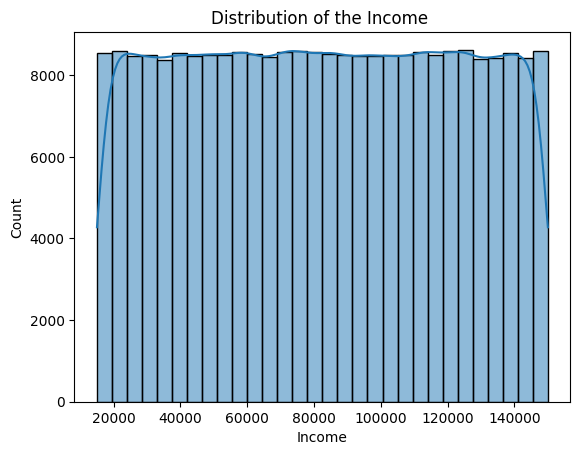

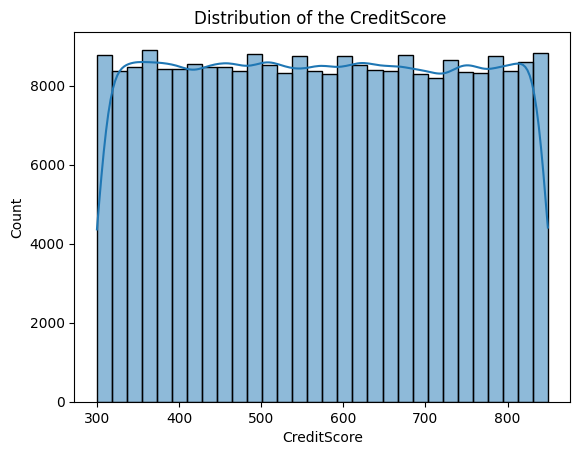

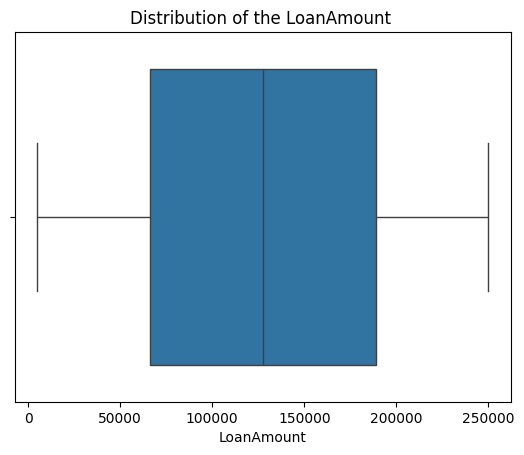

In [7]:
# GRÁFICOS DE VARIABLES NÚMERICAS

# Distribución de ingresos
sns.histplot(df['Income'], kde=True, bins=30)
plt.title('Distribution of the Income ')
plt.show()

# Distribución del puntaje de crédito
sns.histplot(df['CreditScore'], kde=True, bins=30)
plt.title('Distribution of the CreditScore ')
plt.show()

# Boxplot de monto del préstamo
sns.boxplot(x=df['LoanAmount'])
plt.title('Distribution of the LoanAmount ')
plt.show()


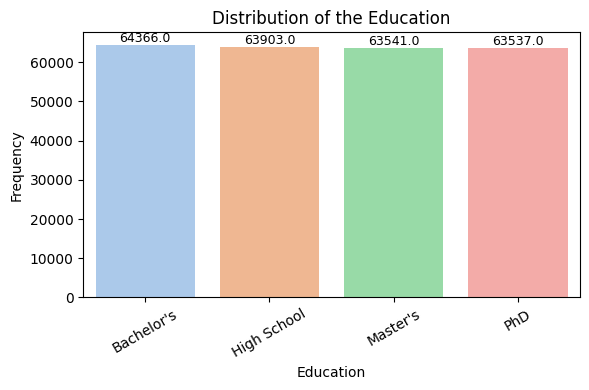

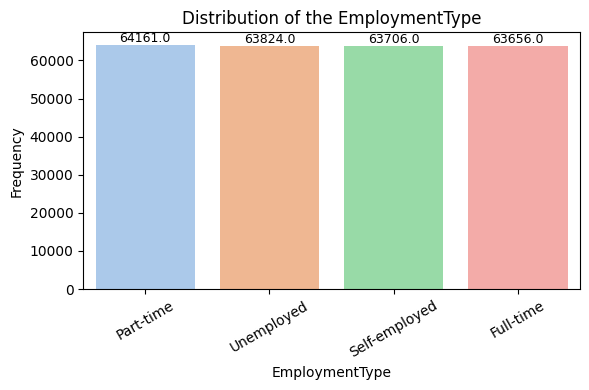

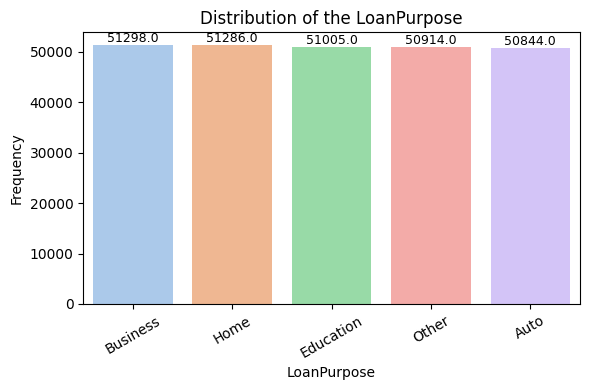

In [8]:
# GRÁFICOS DE VARIABLES CATEGÓRICAS

# Lista de variables categóricas
cat_vars = ['Education', 'EmploymentType', 'LoanPurpose']

# Gráficos con conteo dentro de las barras
for var in cat_vars:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x=var, order=df[var].value_counts().index, palette='pastel')

    # Añadir etiquetas de conteo encima de cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9)

    plt.title(f'Distribution of the {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()



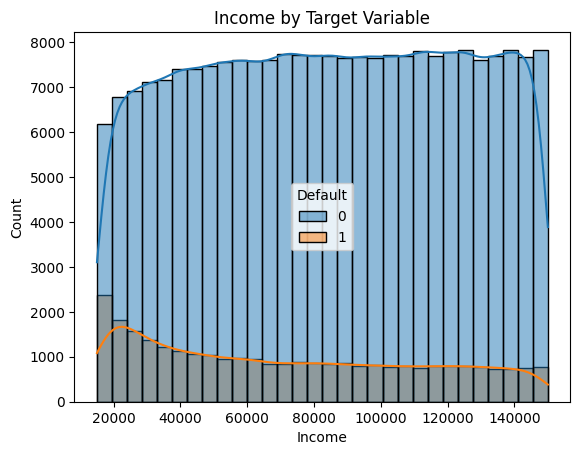

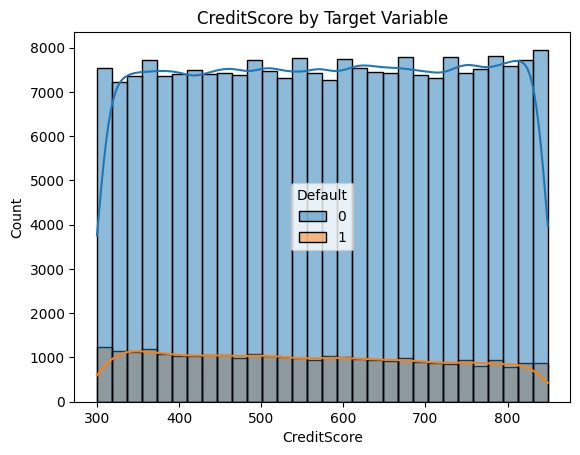

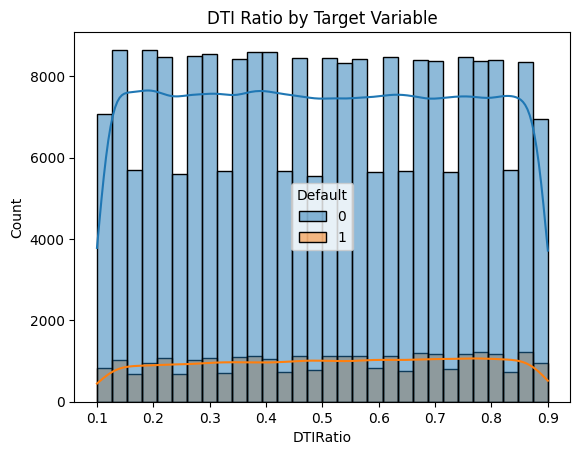

In [9]:
# GRÁFICOS VARIABLES NÚMERICOS VS DEFAULT

# Distribuciones por clase objetivo
sns.histplot(data=df, x='Income', hue='Default', kde=True, bins=30)
plt.title('Income by Target Variable')
plt.show()

sns.histplot(data=df, x='CreditScore', hue='Default', kde=True, bins=30)
plt.title('CreditScore by Target Variable')
plt.show()

sns.histplot(data=df, x='DTIRatio', hue='Default', kde=True, bins=30)
plt.title('DTI Ratio by Target Variable')
plt.show()

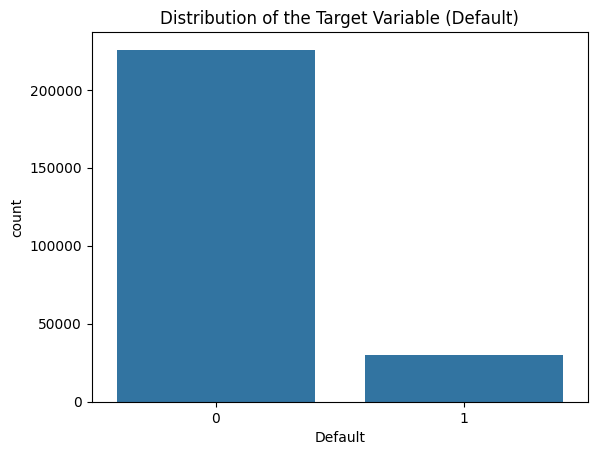

Proporción de clases:
 Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


In [10]:
#GRÁFICO DE LA VARIABLE OBJETIVO

# Análisis de balance de clases
sns.countplot(x='Default', data=df)
plt.title('Distribution of the Target Variable (Default)')
plt.show()

print("Proporción de clases:\n", df['Default'].value_counts(normalize=True))

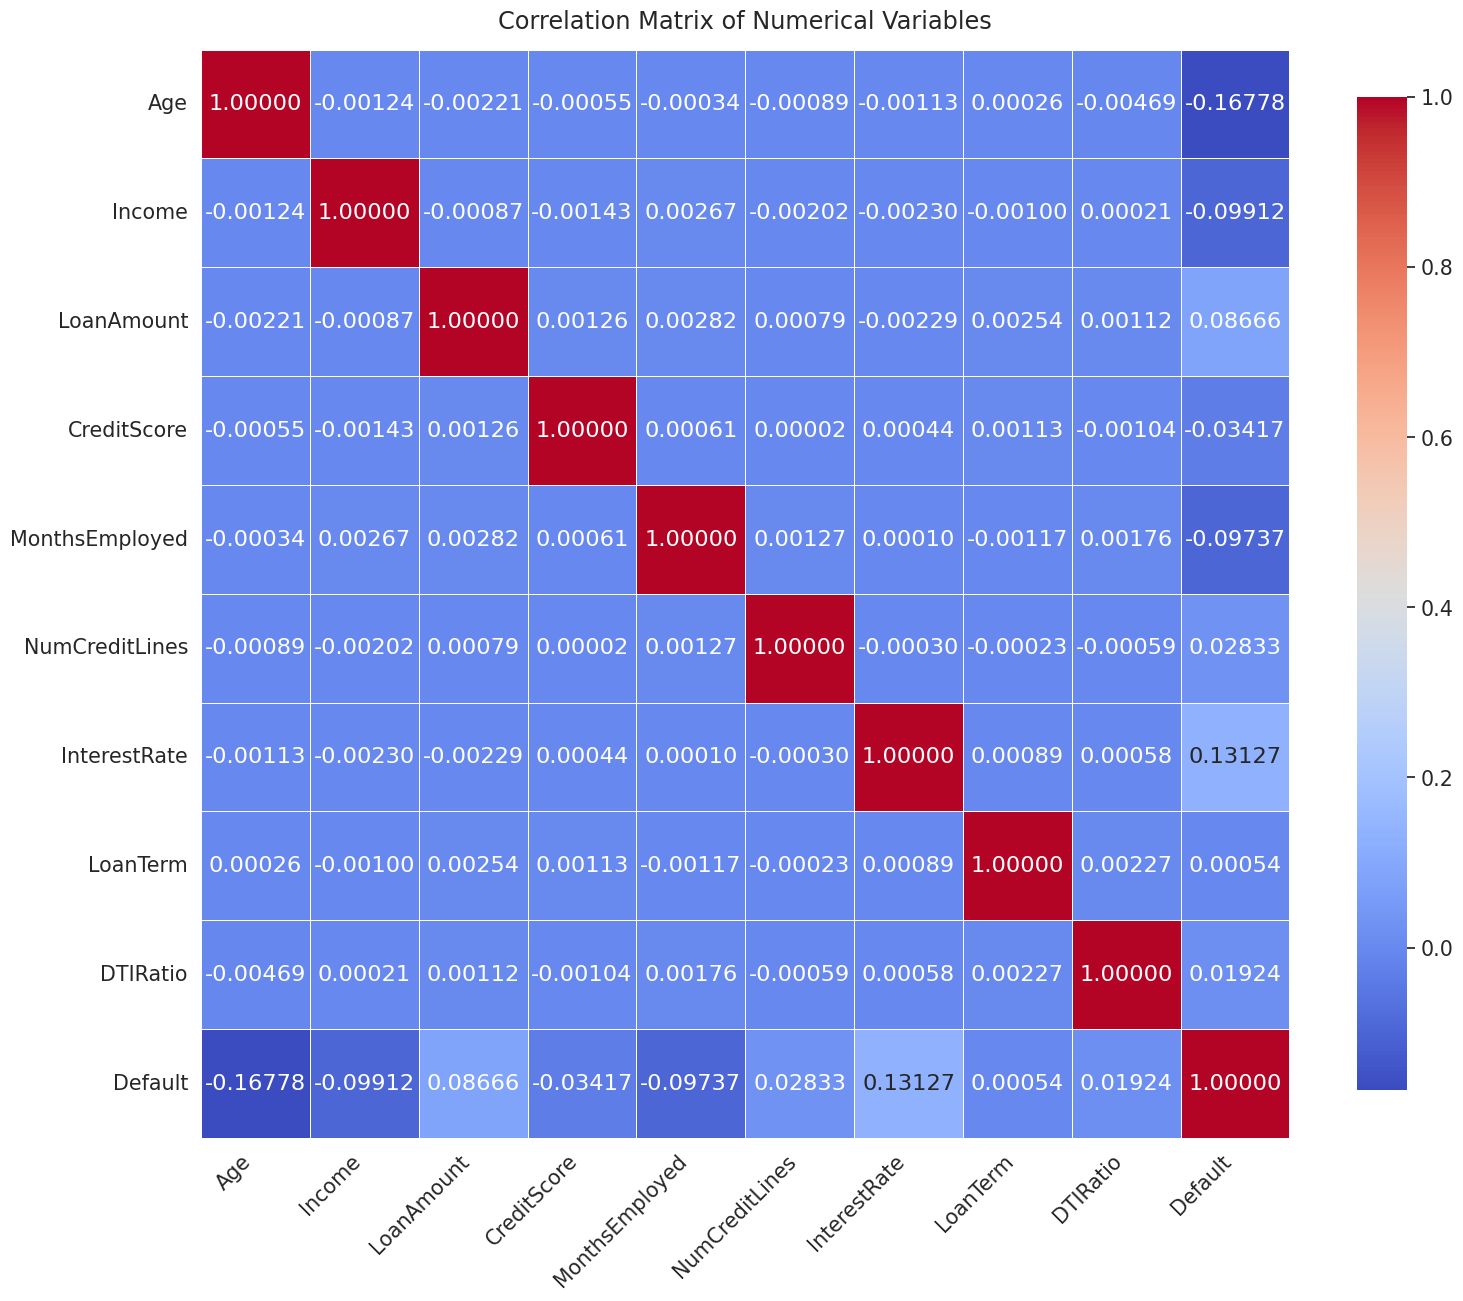

In [11]:
# MATRIZ DE CORRELACIÓN

corr = df.select_dtypes(include='number').corr()

# Tamaño de la figura más grande y ajustes visuales
plt.figure(figsize=(16, 14))  # Más espacio
sns.set(font_scale=1.35)       # Tamaño del texto en el heatmap
sns.heatmap(
    corr,
    annot=True,
    fmt=".5f",                # Formato de los números (2 decimales)
    cmap='coolwarm',
    square=True,
    linewidths=0.6,           # Líneas que separan celdas
    cbar_kws={"shrink": 0.8}  # Reduce el tamaño de la barra de color
)

plt.title('Correlation Matrix of Numerical Variables', fontsize=17.3, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# CREACIÓN DE NUEVAS VARIABLES

# Credit Score Category
def categorize_credit(score):
    if 300 <= score <= 579:
        return 'Low'
    elif 580 <= score <= 739:
        return 'Medium'
    elif 740 <= score <= 850:
        return 'High'
    else:
        return 'Unknown'

df['CreditScoreCategory'] = df['CreditScore'].apply(categorize_credit)

# Has High Debt
df['HasHighDebt'] = df['DTIRatio'] > 0.4

# Loan Term Category
def categorize_loan_term(term):
    if term <= 24:
        return 'Short term'
    elif term <= 48:
        return 'Medium term'
    elif term > 48:
        return 'Long term'
    else:
        return 'Unknown'

df['LoanTermCategory'] = df['LoanTerm'].apply(categorize_loan_term)

df


LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0       I38PQUQS96   56   85994       50587          520              80   
1       HPSK72WA7R   69   50432      124440          458              15   
2       C1OZ6DPJ8Y   46   84208      129188          451              26   
3       V2KKSFM3UN   32   31713       44799          743               0   
4       EY08JDHTZP   60   20437        9139          633               8   
...            ...  ...     ...         ...          ...             ...   
255342  8C6S86ESGC   19   37979      210682          541             109   
255343  98R4KDHNND   32   51953      189899          511              14   
255344  XQK1UUUNGP   56   84820      208294          597              70   
255345  JAO28CPL4H   42   85109       60575          809              40   
255346  ZTH91CGL0B   62   22418       18481          636             113   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  ... EmploymentType  \
0                    4         15.23        36      0.44  ...      Full-time   
1                    1          4.81        60      0.68  ...      Full-time   
2                    3         21.17        24      0.31  ...     Unemployed   
3                    3          7.07        24      0.23  ...      Full-time   
4                    4          6.51        48      0.73  ...     Unemployed   
...                ...           ...       ...       ...  ...            ...   
255342               4         14.11        12      0.85  ...      Full-time   
255343               2         11.55        24      0.21  ...      Part-time   
255344               3          5.29        60      0.50  ...  Self-employed   
255345               1         20.90        48      0.44  ...      Part-time   
255346               2          6.73        12      0.48  ...     Unemployed   

       MaritalStatus HasMortgage HasDependents LoanPurpose HasCoSigner  \
0           Divorced         Yes           Yes       Other         Yes   
1            Married          No            No       Other         Yes   
2           Divorced         Yes           Yes        Auto          No   
3            Married          No            No    Business          No   
4           Divorced          No           Yes        Auto          No   
...              ...         ...           ...         ...         ...   
255342       Married          No            No       Other          No   
255343      Divorced          No            No        Home          No   
255344       Married         Yes           Yes        Auto         Yes   
255345        Single         Yes           Yes       Other          No   
255346      Divorced         Yes            No   Education         Yes   

       Default  CreditScoreCategory HasHighDebt  LoanTermCategory  
0            0                  Low        True       Medium term  
1            0                  Low        True         Long term  
2            1                  Low       False        Short term  
3            0                 High       False        Short term  
4            0               Medium        True       Medium term  
...        ...                  ...         ...               ...  
255342       0                  Low        True        Short term  
255343       1                  Low       False        Short term  
255344       0               Medium        True         Long term  
255345       0                 High        True       Medium term  
255346       0               Medium        True        Short term  

[255347 rows x 21 columns]

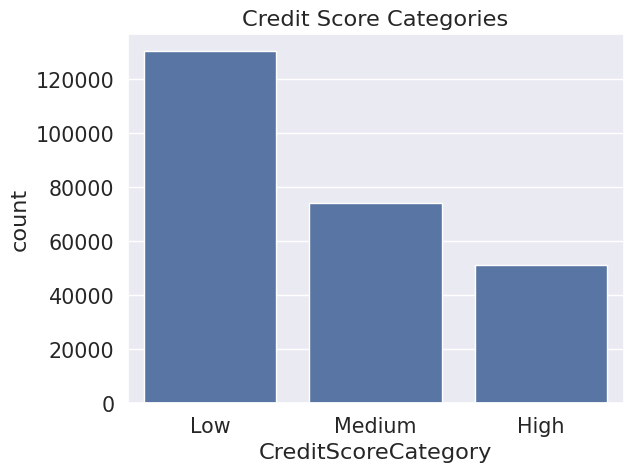

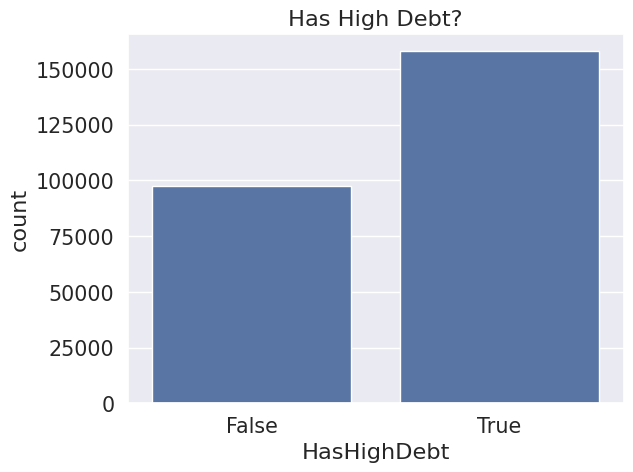

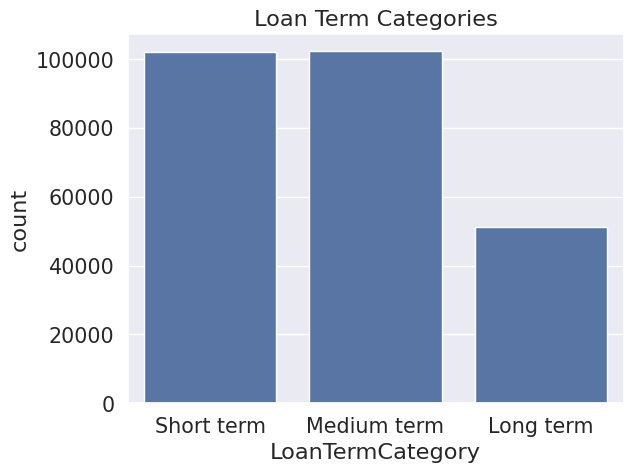

In [13]:
# GRÁFICOS DE LA NUEVAS VARIABLES

# Credit Score Category
sns.countplot(data=df, x='CreditScoreCategory', order=['Low', 'Medium', 'High'])
plt.title('Credit Score Categories')
plt.show()

# Has High Debt
sns.countplot(data=df, x='HasHighDebt')
plt.title('Has High Debt?')
plt.show()

# Loan Term Category
sns.countplot(data=df, x='LoanTermCategory', order=['Short term', 'Medium term', 'Long term'])
plt.title('Loan Term Categories')
plt.show()


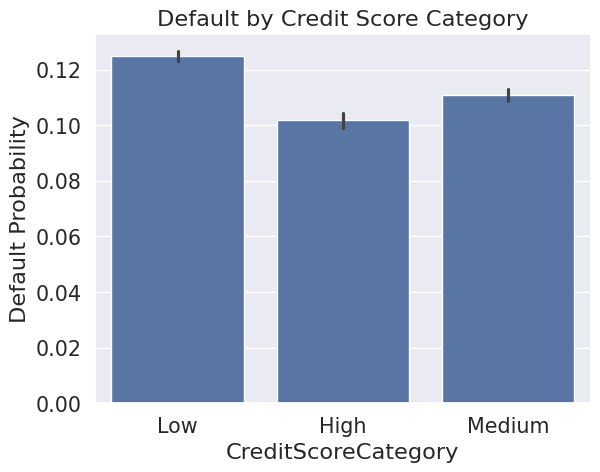

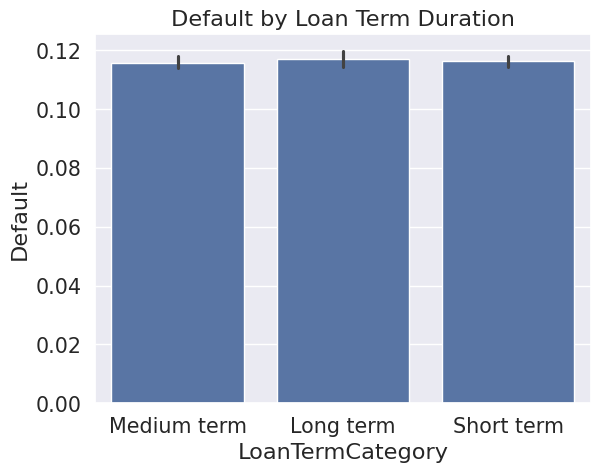

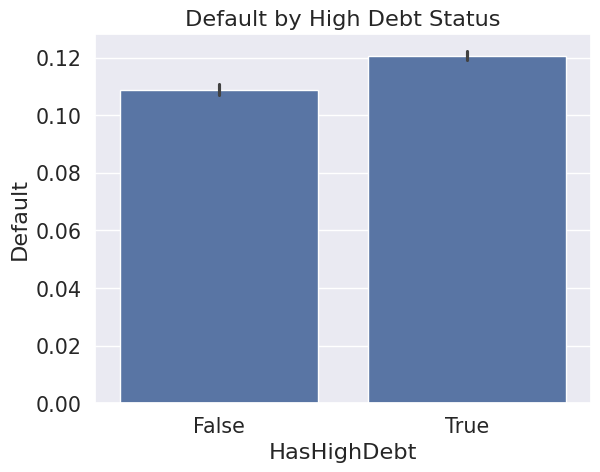

In [14]:
# GRÁFICOS DE LAS NUEVAS VARIABLES VS DEFAULT

# Default by Credit Score Category
sns.barplot(data=df, x='CreditScoreCategory', y='Default')
plt.title('Default by Credit Score Category')
plt.ylabel('Default Probability')
plt.show()

# Default by Loan Term Duration
sns.barplot(data=df, x='LoanTermCategory', y='Default')
plt.title('Default by Loan Term Duration')
plt.show()

# Default vs High Debt
sns.barplot(data=df, x='HasHighDebt', y='Default')
plt.title('Default by High Debt Status')
plt.show()


In [15]:
# GRÁFICOS INTERACTIVOS

# Income vs Loan Amount Scatter Plot
fig = px.scatter(df, x='Income', y='LoanAmount', color='Default', title='Income vs Loan Amount')
fig.show()

# Credit Score Histogram by Category (Ordered with Light Colors)
fig = px.histogram(
    df,
    x='CreditScore',
    color='CreditScoreCategory',
    nbins=30,
    category_orders={'CreditScoreCategory': ['Low', 'Medium', 'High']},
    color_discrete_map={
        'Low': '#FF9999',     # Light red
        'Medium': '#FFFF99',  # Light yellow
        'High': '#99FF99'     # Light green
    }
)
fig.show()




**NORMALIZACIÓN DE LA VARIABLE INCOME**

In [16]:
# ESTANDARIZACIÓN
scaler = StandardScaler()
df['Income_normalized'] = scaler.fit_transform(df[['Income']])

In [17]:
# CREACIÓN GRUPOS BASADOS EN LA MEDIA (Z-SCORE)
df['IncomeGroup'] = pd.cut(
    df['Income_normalized'],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=['Below Average', 'Around Average', 'Above Average']
)


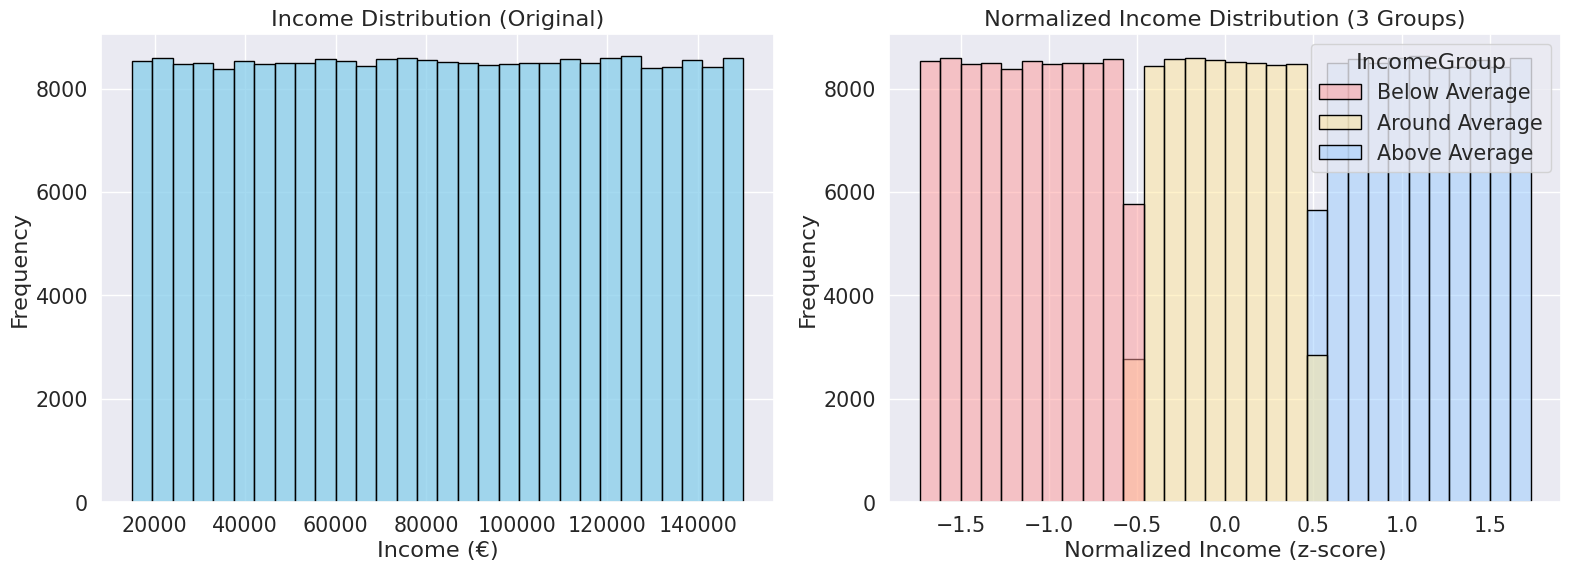

In [18]:
# GRÁFICOS DE COMPARTIVA INCOME VS INCOME_NORMALIZED

# Create comparison chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of original Income
sns.histplot(data=df, x='Income', bins=30, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Income Distribution (Original)')
axes[0].set_xlabel('Income (€)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Histogram of normalized Income, segmented by group
sns.histplot(data=df, x='Income_normalized', bins=30, hue='IncomeGroup',
             palette=['#FF9999', '#FFE699', '#99CCFF'], edgecolor='black', ax=axes[1])
axes[1].set_title('Normalized Income Distribution (3 Groups)')
axes[1].set_xlabel('Normalized Income (z-score)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Show
plt.tight_layout()
plt.show()


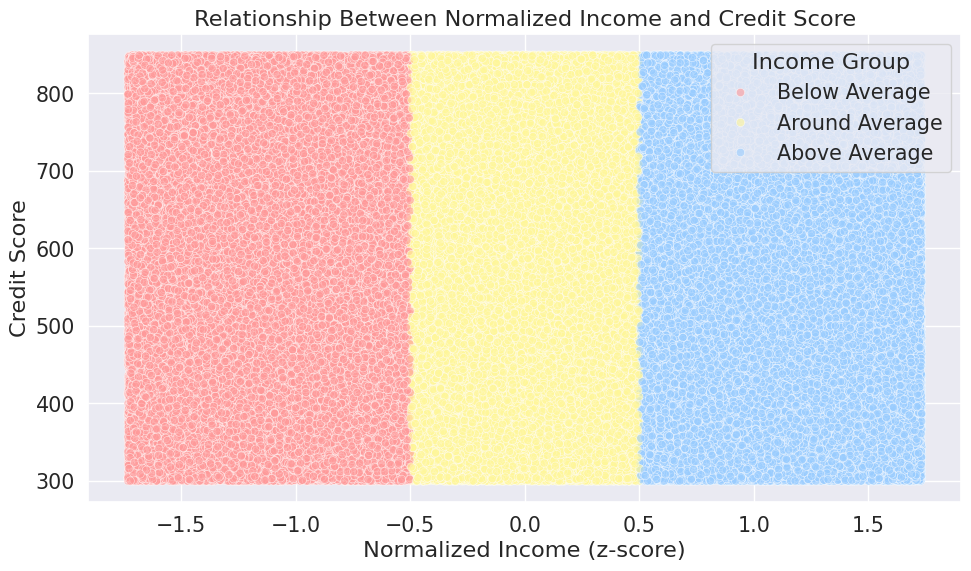

In [19]:
# GRÁFICO DE DISPERSIÓN DE INGRESO NORMALIZADO VS PUNTUACIÓN DE CRÉDITO
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Income_normalized',
    y='CreditScore',
    hue='IncomeGroup',
    palette={
        'Below Average': '#FF9999',
        'Around Average': '#FFF699',
        'Above Average': '#99CCFF'
    },
    alpha=0.6
)

plt.title('Relationship Between Normalized Income and Credit Score')
plt.xlabel('Normalized Income (z-score)')
plt.ylabel('Credit Score')
plt.grid(True)
plt.legend(title='Income Group')
plt.tight_layout()
plt.show()


**FEATURE IMPORTANCE / MUTUAL INFORMATION**

In [20]:
# ELIMINACIÓN DE LA VARIABLE TARGET

X = df.drop(columns='Default')
y = df['Default']

In [21]:
# IDENTIFICACIÓN DE VARIABLES CATEGÓRICAS Y ELIMINACIÓN DE LA CARDINALIDAD

cat_base = ['CreditScoreCategory', 'LoanTermCategory','HasHighDebt']
cat_features = [col for col in cat_base if col in X.columns]
cat_features += list(X.select_dtypes(include='object').columns)
cat_features = list(set(cat_features))  # Quitar duplicados
cat_features = [col for col in cat_features if X[col].nunique() <= 50]  # Eliminar alta cardinalidad

In [22]:
# IDENTIFICACIÓN DE VARIABLES NUMÉRICAS

# Variables numéricas
num_features = df.select_dtypes(include=['int64', 'float64']) \
                 .drop(columns=['Default', 'Income_normalized','IncomeGroup'], errors='ignore') \
                 .columns.tolist()

# Mostrar columnas eliminadas
dropped_columns = ['Default', 'Income_normalized']
print(f"Columnas eliminadas del conjunto numérico: {dropped_columns}")

Columnas eliminadas del conjunto numérico: ['Default', 'Income_normalized']


In [23]:
# APLICAR PREPROCESAMIENTO CON COLUMTRANSFORMER
# Aplicar preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(), cat_features)
    ],
    remainder='drop'  # Elimina columnas no especificadas
)
X_prepared = preprocessor.fit_transform(X)

In [24]:
# RECONSTRUIR DATAFRAME TRANSFORMADO

feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()
feature_names = num_features + feature_names_cat
X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names)


In [25]:
# IMPORTANCIA DE VARIABLES (RANDOM FOREST)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_prepared_df, y)
importances = rf.feature_importances_


In [26]:
# MUTUAL INFORMATION
mi = mutual_info_classif(X_prepared_df, y, random_state=42)

In [27]:
# CREAR SERIES NOMBRADAS Y ORDENADAS CON RESULTADOS DE IMPORTANCIA Y COMBINACIÓN RESULTADOS EN UN SOLO DATAFRAME
# Crear Series nombradas y ordenadas
rf_importance = pd.Series(importances, index=X_prepared_df.columns, name="RandomForestImportance").sort_values(ascending=False)
mi_scores = pd.Series(mi, index=X_prepared_df.columns, name="MutualInformation").sort_values(ascending=False)

# Combinar ambas en un solo DataFrame
importancias_df = pd.concat([rf_importance, mi_scores], axis=1)

# Mostrar tabla en notebook
print("\nTabla combinada de Importancia y Mutual Information:")
display(importancias_df)

# También mostrar columnas eliminadas
print("\nColumnas eliminadas por el ColumnTransformer:")
print(dropped_columns)

# Mostrar dimensiones del dataset procesado
print(f"\nDimensiones después del preprocesamiento: {X_prepared_df.shape}")
print(f"\nDimensiones después del preprocesamiento: {X_prepared_df.shape}")



Tabla combinada de Importancia y Mutual Information:


RandomForestImportance  MutualInformation
Income                             0.126182           0.007672
InterestRate                       0.120640           0.008726
LoanAmount                         0.114237           0.003612
Age                                0.097938           0.015106
CreditScore                        0.097477           0.001503
MonthsEmployed                     0.095346           0.005174
DTIRatio                           0.084605           0.001151
LoanPurpose                        0.037433           0.010147
LoanTerm                           0.032354           0.008839
NumCreditLines                     0.030374           0.009846
Education                          0.030234           0.010397
EmploymentType                     0.028861           0.011927
MaritalStatus                      0.024591           0.018677
LoanTermCategory                   0.018410           0.019239
CreditScoreCategory                0.014735           0.018953
HasMortgage                        0.014644           0.034267
HasDependents                      0.011842           0.034732
HasCoSigner                        0.010569           0.035522
HasHighDebt                        0.009527           0.040012


Columnas eliminadas por el ColumnTransformer:
['Default', 'Income_normalized']

Dimensiones después del preprocesamiento: (255347, 19)

Dimensiones después del preprocesamiento: (255347, 19)


# **PCA**

In [28]:
# ELIMINACIÓN DE COLUMNAS IDENTIFICADORAS SI EXISTEN
df_sample = df.drop(columns=["LoanID"], errors="ignore")

In [29]:
# CONVERSIÓN DE VARIABLES CATEGÓRICAS A NUMÉRICAS CON LABELENCODER
df_encoded = df_sample.copy()
label_encoders = {}  # para guardar los label encoders aplicados

for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # guardar el encoder por si se necesita revertir

In [30]:
# SEPARACIÓN DE LA VARIABLE OBJETIVO
if 'Default' in df_encoded.columns:
    y = df_encoded['Default']
    X = df_encoded.drop(columns=['Default'])
else:
    X = df_encoded

In [31]:
# ESCALADO DE VARIABLES NUMÉRICAS PARA PCA
numeric_features = X.select_dtypes(include=['int64','float64']).columns.values.tolist()
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=X)

In [32]:
X_transformed.shape

(255347, 21)

In [33]:
# APLICACIÓN DE PCA
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X_transformed)
X_pca.shape

(255347, 14)

In [34]:
# CÁLCULO DE VARIANZA EXPLICADA Y VARIANZA ACUMULADA
PCAnames = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)]
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, index = PCAnames, columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance

Exp_variance  cum_Exp_variance
PC1       0.139144          0.139144
PC2       0.092623          0.231767
PC3       0.087682          0.319449
PC4       0.056100          0.375548
PC5       0.048105          0.423654
PC6       0.048030          0.471684
PC7       0.047900          0.519584
PC8       0.047823          0.567407
PC9       0.047691          0.615098
PC10      0.047639          0.662736
PC11      0.047613          0.710350
PC12      0.047545          0.757895
PC13      0.047405          0.805300
PC14      0.047325          0.852625

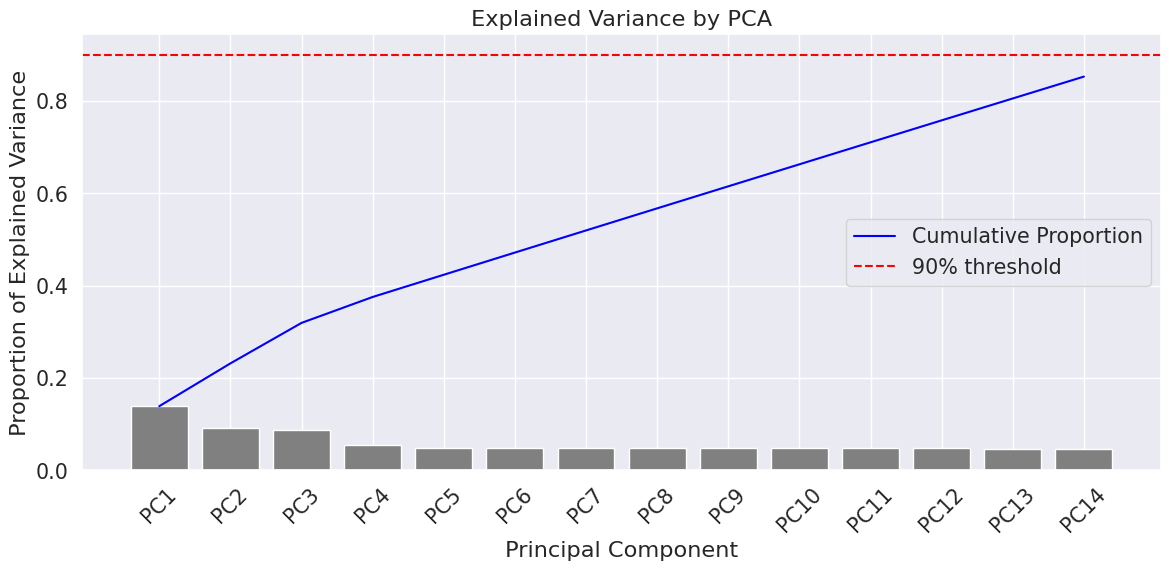

In [35]:
# VISUALIZACIÓN DE LA VARIANZA EXPLICADA POR COMPONENTE PRINCIPAL

plt.figure(figsize=(12, 6))

# Gray bars for individual explained variance
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')

# Blue line for cumulative explained variance
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Cumulative Proportion')

# Chart aesthetics
plt.axhline(0.9, color='red', linestyle='--', label='90% threshold')
plt.ylabel('Proportion of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Explained Variance by PCA')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# MATRIZ DE CARGAS (LOADINGS) DE LAS VARIABLES ORIGINALES EN LOS COMPONENTES

loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=X.columns)  # Usa las columnas del X ya codificado
loadings

PC1       PC2       PC3       PC4       PC5  \
Age                 -0.001239  0.000987 -0.009020 -0.002851 -0.195567   
Income               0.581279  0.002219  0.000466  0.000218  0.001175   
LoanAmount          -0.000762  0.003503  0.001041 -0.007748  0.193532   
CreditScore         -0.001281  0.000678 -0.000105  0.706582 -0.010108   
MonthsEmployed       0.002201 -0.001454  0.004057  0.017891  0.194074   
NumCreditLines      -0.001959 -0.000323  0.000081  0.008992  0.211466   
InterestRate        -0.002477  0.001170 -0.000617  0.001794  0.163912   
LoanTerm            -0.002384  0.706743 -0.021529  0.002075  0.002246   
DTIRatio            -0.000318  0.021955  0.706690 -0.002298 -0.002253   
Education           -0.000876 -0.004182  0.001648  0.000368  0.550959   
EmploymentType      -0.004665  0.001810 -0.000385  0.019162 -0.008172   
MaritalStatus        0.000665 -0.001316  0.007019 -0.011392 -0.423029   
HasMortgage         -0.000972  0.001771  0.002416  0.019081  0.024709   
HasDependents       -0.001622  0.003050  0.002163 -0.002795  0.253463   
LoanPurpose         -0.001737  0.003895 -0.006007 -0.004768 -0.443739   
HasCoSigner         -0.003077 -0.001975  0.000441 -0.010629  0.265670   
CreditScoreCategory -0.001255  0.004516 -0.003504 -0.706576  0.002153   
HasHighDebt         -0.001443  0.021375  0.706713 -0.001076 -0.003273   
LoanTermCategory     0.002958 -0.706731  0.021724 -0.001839 -0.001975   
Income_normalized    0.581279  0.002219  0.000466  0.000218  0.001175   
IncomeGroup         -0.569345 -0.002218 -0.000973  0.000323 -0.000238   

                          PC6       PC7       PC8       PC9      PC10  \
Age                  0.234773  0.164935 -0.118367  0.585715  0.143872   
Income               0.000526  0.000510  0.001212  0.002219 -0.002360   
LoanAmount          -0.187480  0.202247  0.623516 -0.060069  0.101950   
CreditScore          0.007892 -0.012673  0.010466 -0.000171 -0.009207   
MonthsEmployed      -0.254197  0.166781  0.135638  0.088521  0.758611   
NumCreditLines      -0.082871 -0.397670  0.337218  0.045321  0.009728   
InterestRate         0.554347  0.030681  0.117895  0.071672  0.041171   
LoanTerm            -0.001147 -0.002275 -0.002198 -0.002392  0.000093   
DTIRatio             0.006213 -0.002393  0.000253  0.006465 -0.000573   
Education            0.198532 -0.028567  0.127191 -0.050054 -0.348203   
EmploymentType      -0.187620  0.388995  0.373685  0.320551 -0.422828   
MaritalStatus       -0.447526  0.085662  0.059966 -0.181231 -0.187529   
HasMortgage          0.132579  0.478915 -0.119801 -0.478746 -0.079976   
HasDependents       -0.196826  0.376426 -0.297410  0.427382 -0.122295   
LoanPurpose          0.201703 -0.216764  0.356954  0.234034 -0.086468   
HasCoSigner         -0.398402 -0.408848 -0.247026  0.182896 -0.165814   
CreditScoreCategory  0.014104  0.011891  0.020602 -0.006274  0.001310   
HasHighDebt          0.005007 -0.001726  0.000400  0.004796  0.000418   
LoanTermCategory     0.001060  0.002565  0.001828  0.001246 -0.000142   
Income_normalized    0.000526  0.000510  0.001212  0.002219 -0.002360   
IncomeGroup          0.000230  0.000258 -0.001192 -0.001638  0.002893   

                         PC11      PC12      PC13      PC14  
Age                 -0.572534  0.031279 -0.038937 -0.233620  
Income               0.000305  0.001667  0.001183  0.000651  
LoanAmount          -0.110314 -0.527210 -0.029067  0.108029  
CreditScore          0.001108 -0.031116 -0.000530 -0.006094  
MonthsEmployed       0.110021  0.267294  0.204367 -0.045514  
NumCreditLines      -0.299325  0.573636 -0.372479  0.243036  
InterestRate         0.573124  0.254608 -0.018059 -0.086912  
LoanTerm            -0.000223  0.000858 -0.000395 -0.002448  
DTIRatio            -0.002962 -0.002791  0.001227 -0.000963  
Education           -0.203686 -0.061632 -0.060574 -0.152497  
EmploymentType       0.118695  0.304851  0.291662 -0.291974  
MaritalStatus        0.126531  0.215320 -0.331634 -0.164126  
HasMor

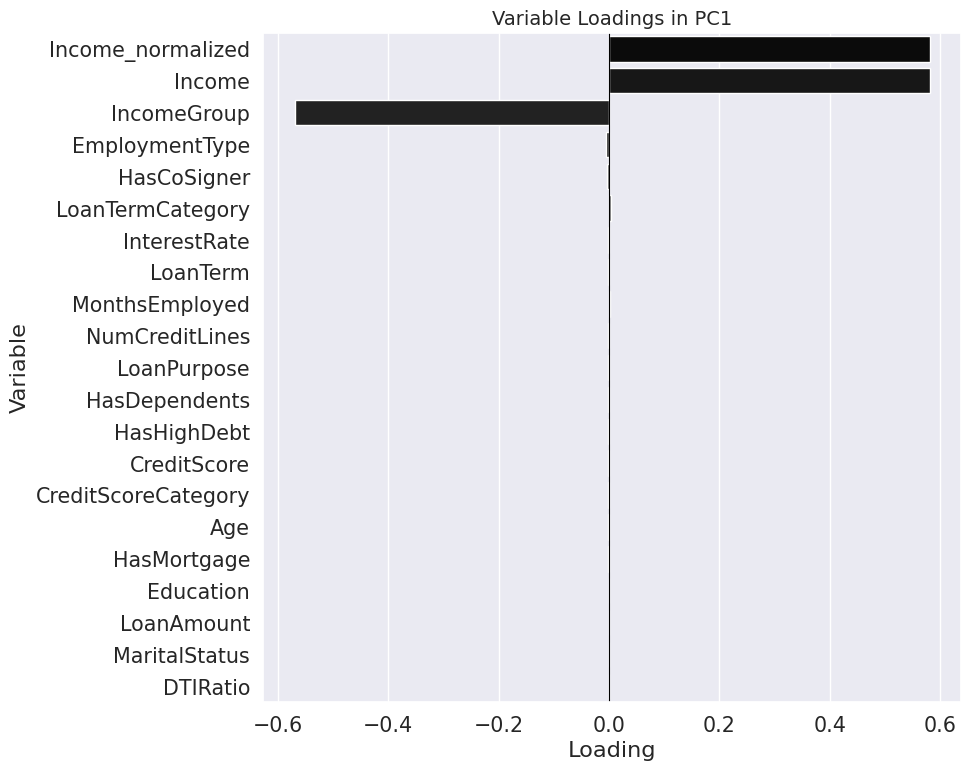

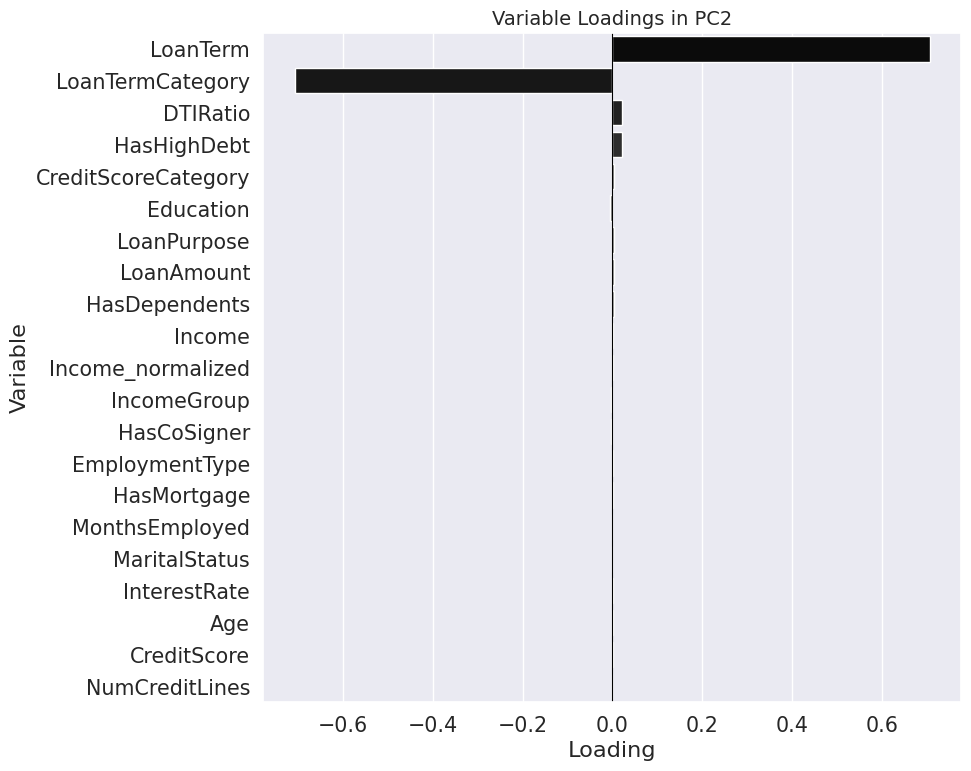

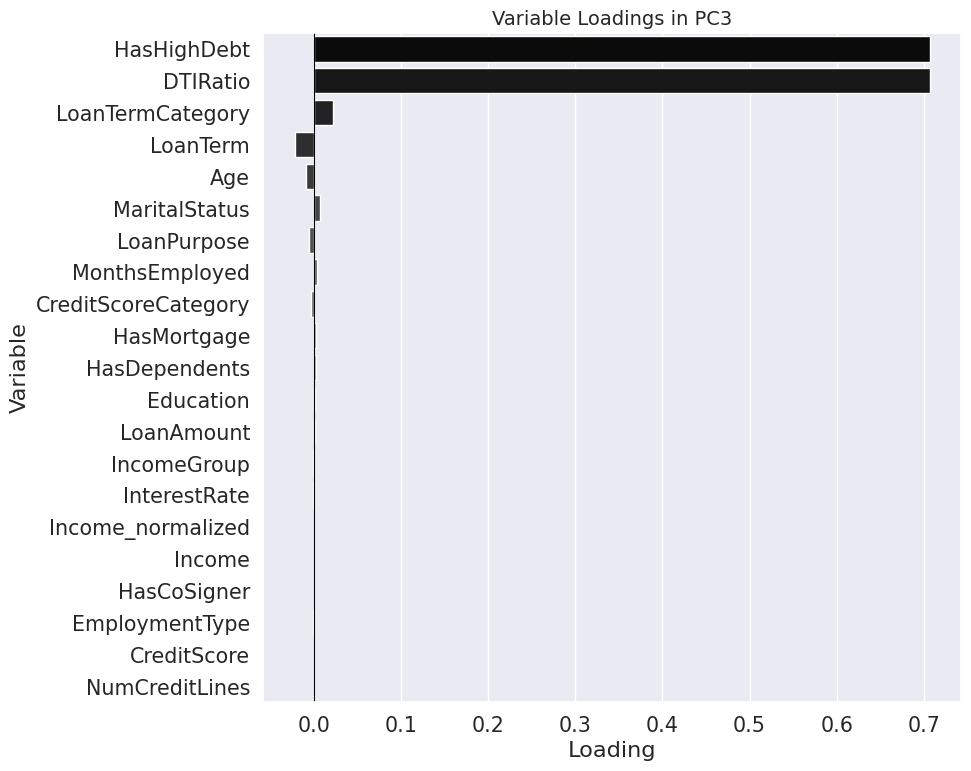

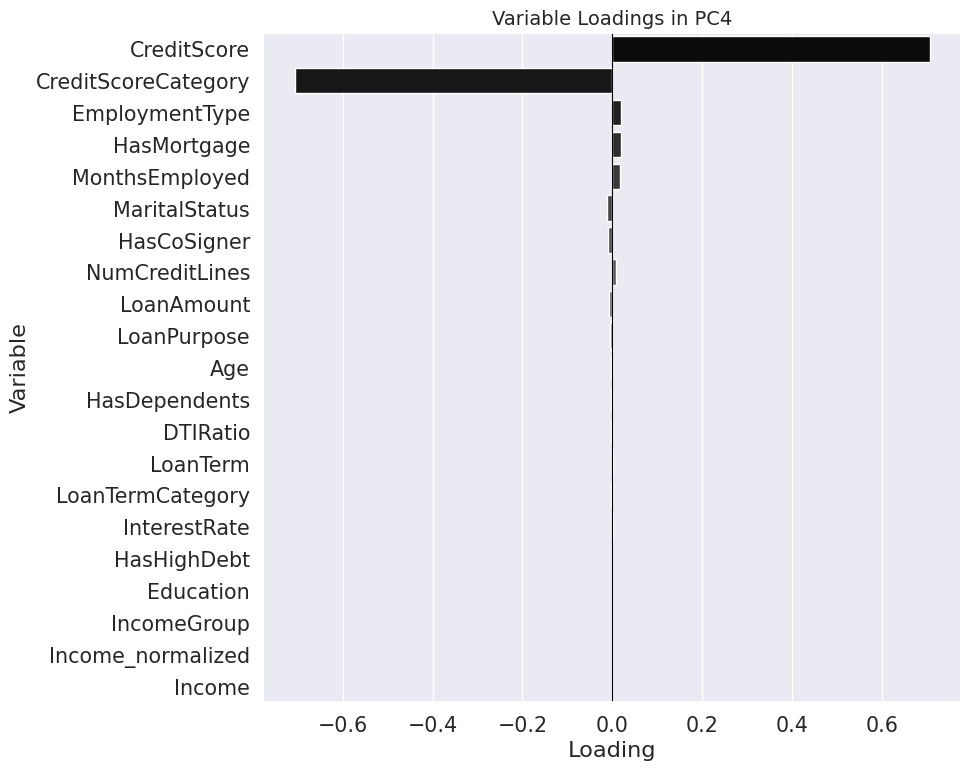

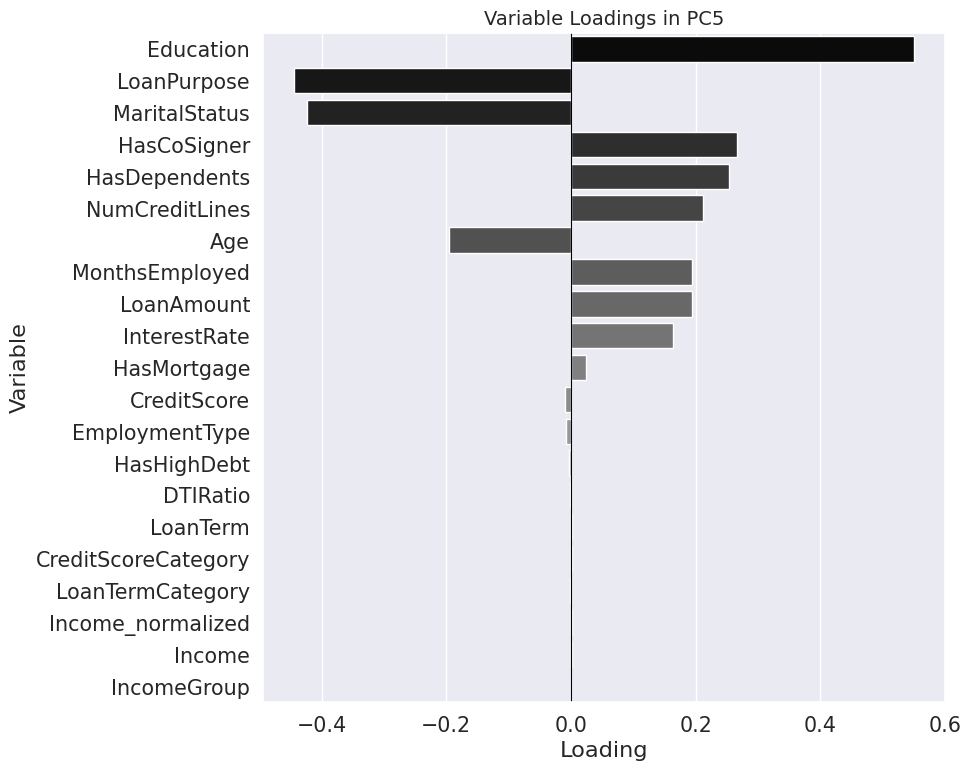

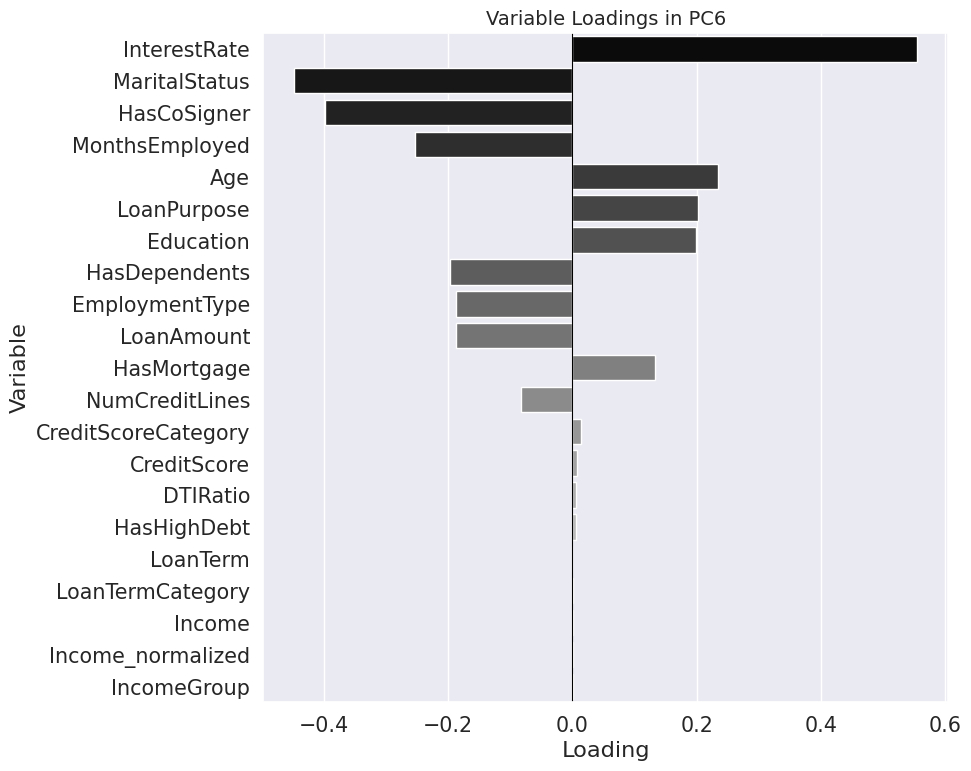

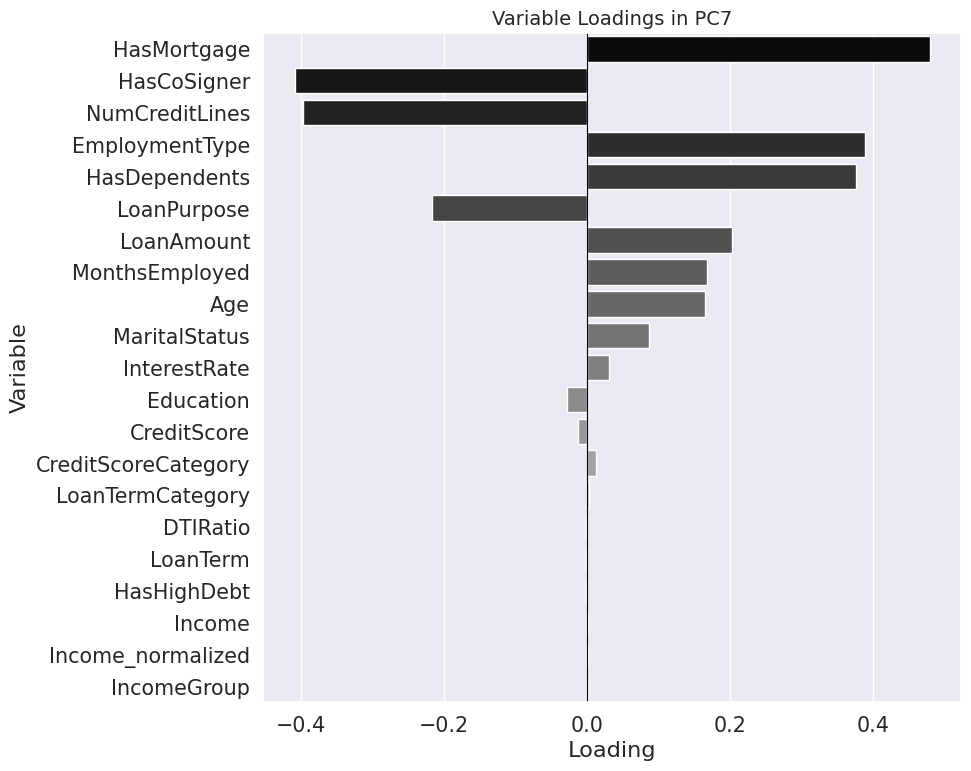

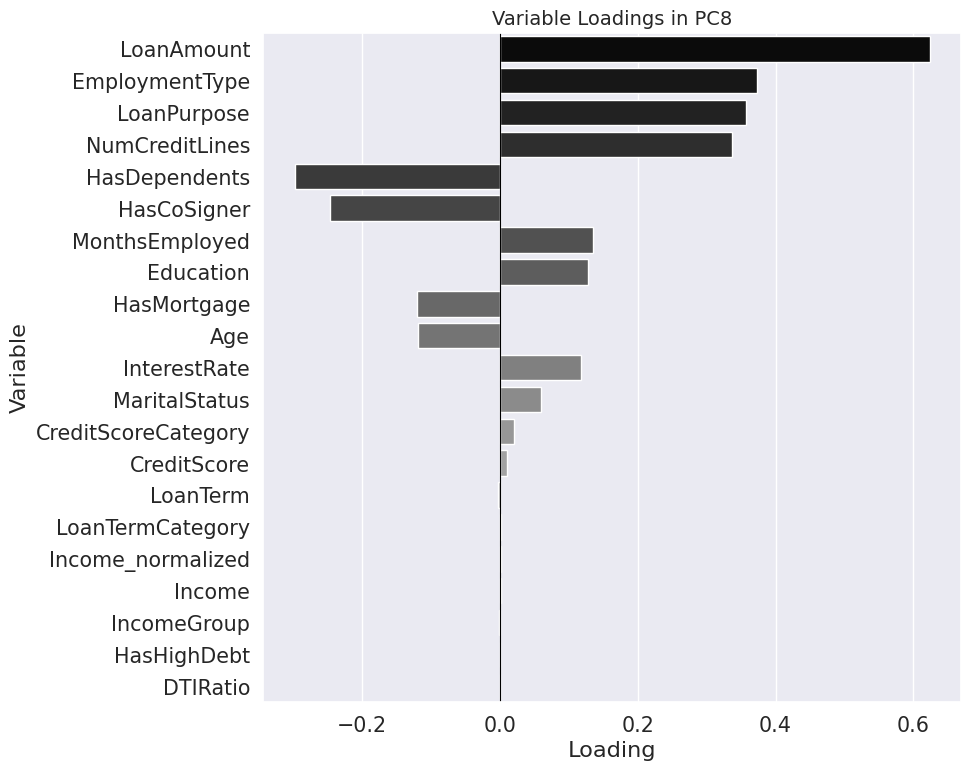

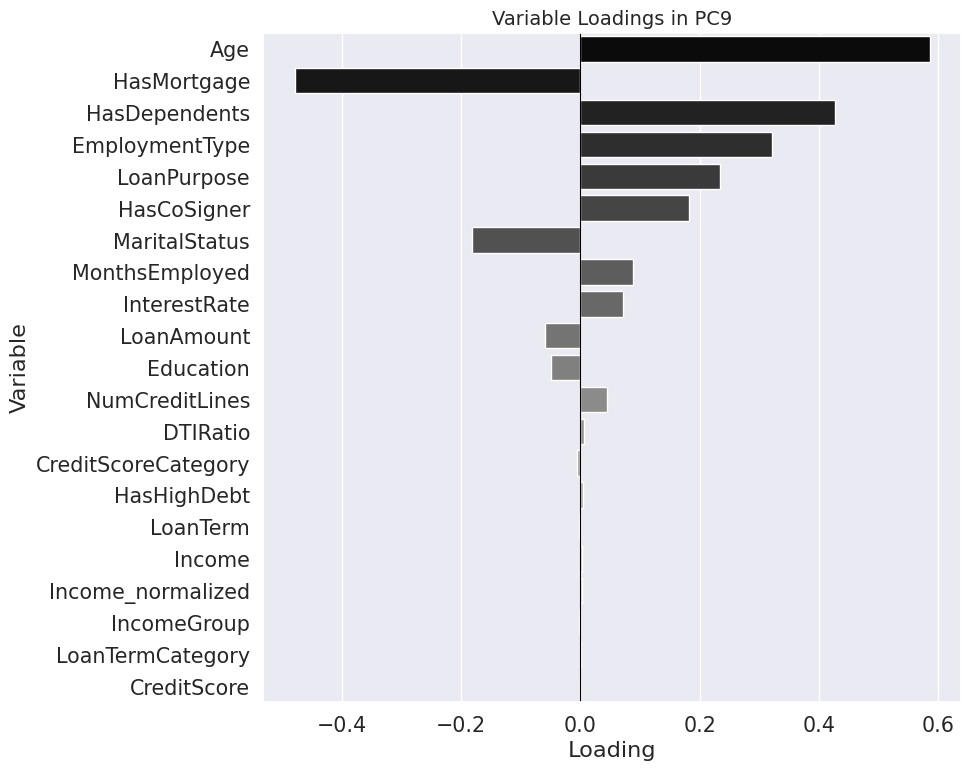

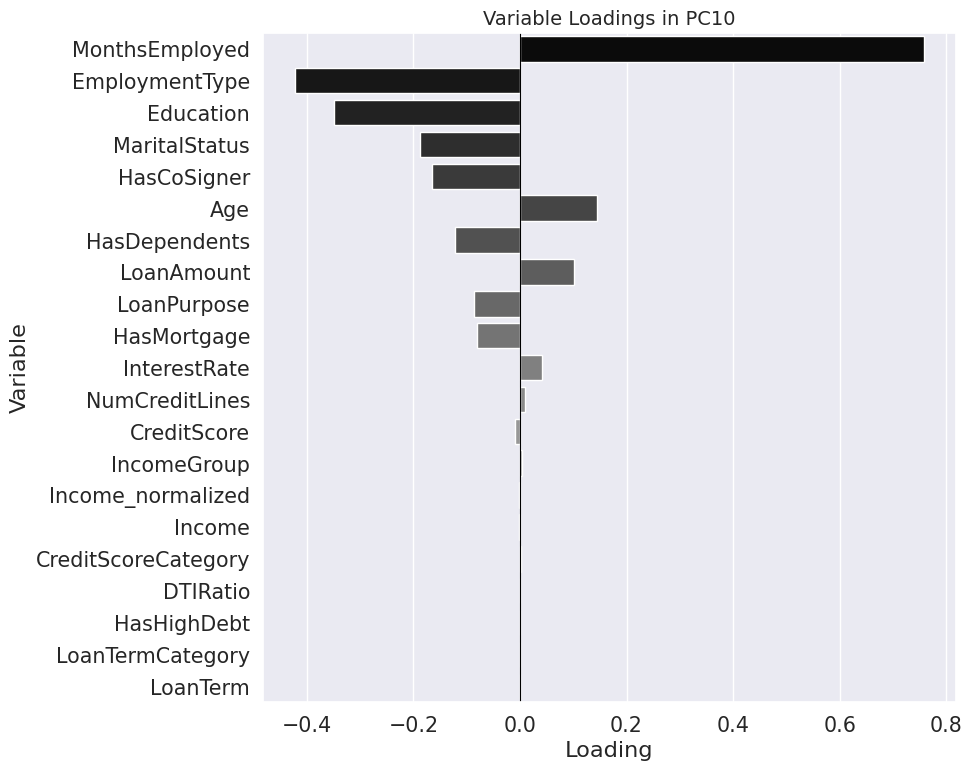

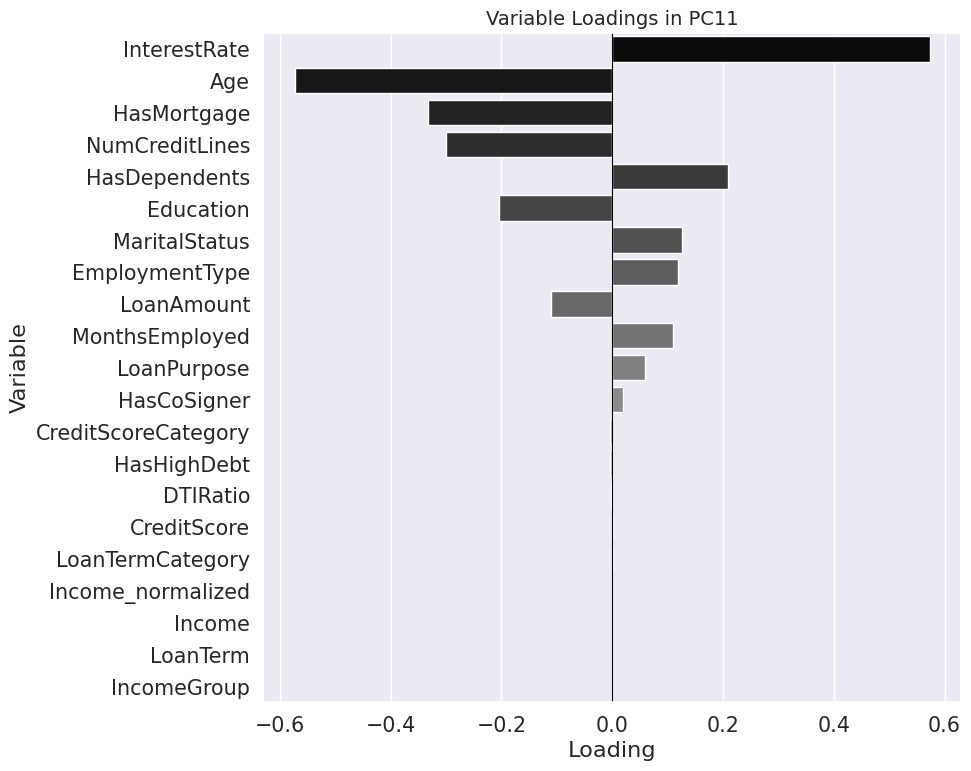

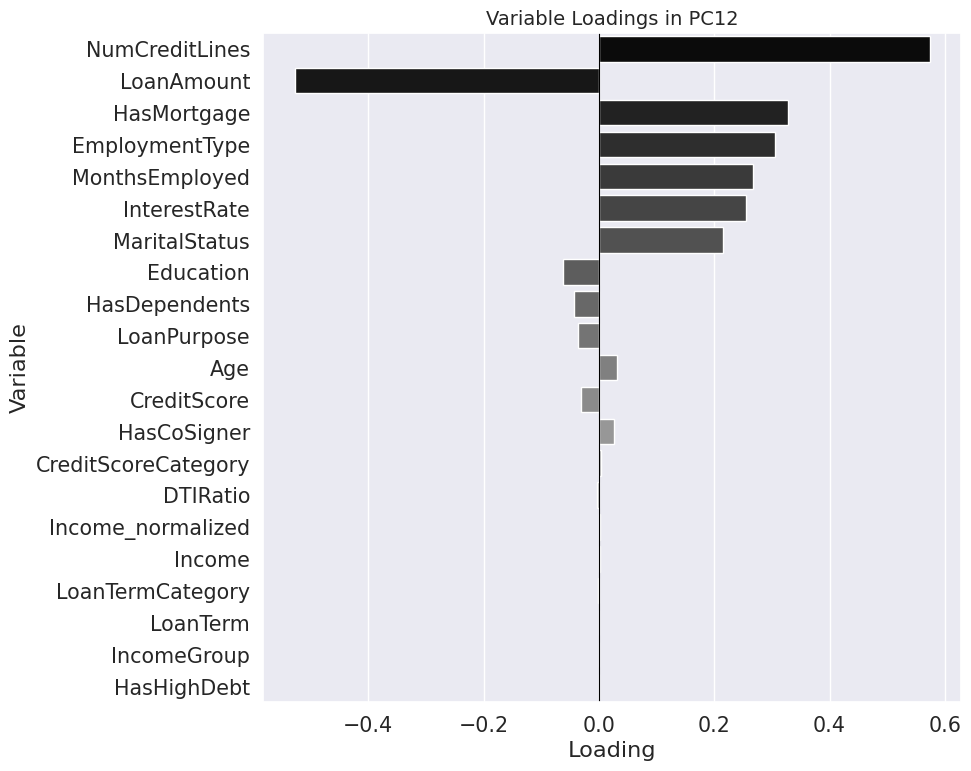

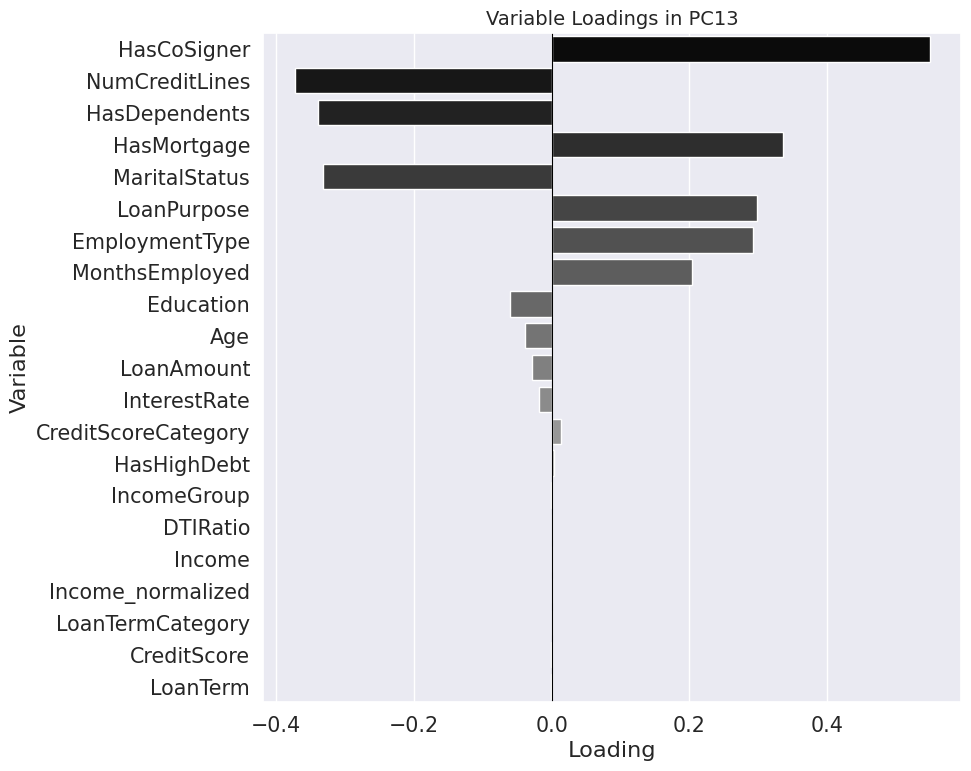

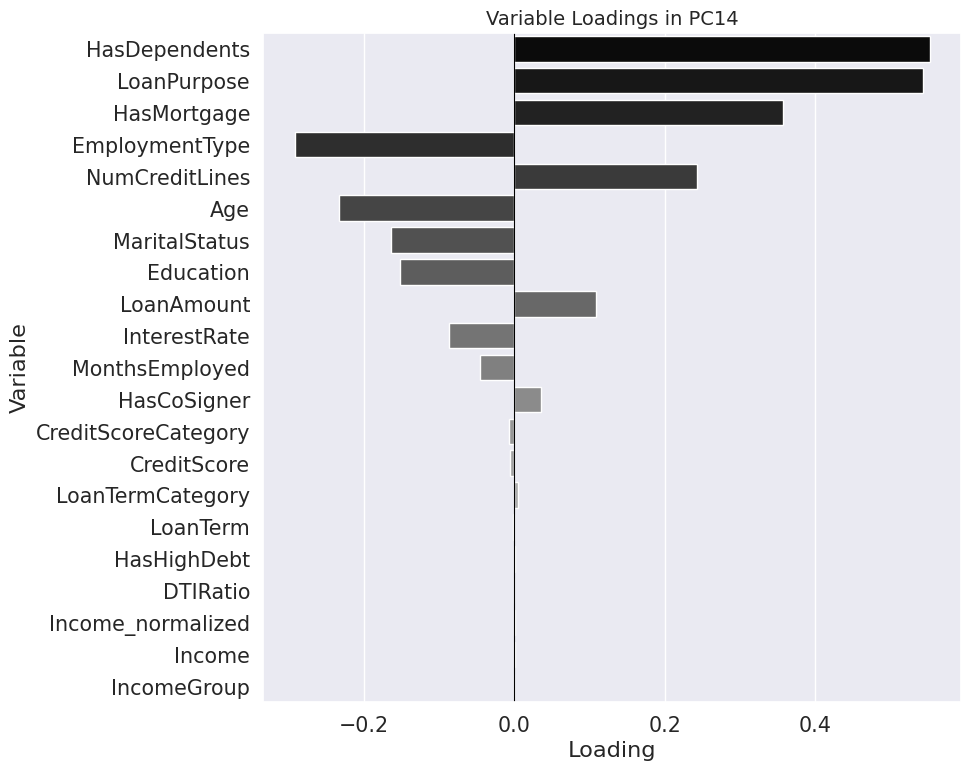

In [37]:
# VISUALIZACIÓN DE LAS 3 PRIMERAS COMPONENTES PRINCIPALES CON MAYOR CONTRIBUCIÓN

for i in range(14):
    pc = f'PC{i+1}'
    # Create a series sorted by absolute magnitude
    sorted_loadings = loadings[pc].sort_values(key=abs, ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=sorted_loadings.values, y=sorted_loadings.index, palette='gray')
    plt.title(f'Variable Loadings in {pc}', fontsize=14)
    plt.xlabel('Loading')
    plt.ylabel('Variable')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()


# **MODELOS CON TODAS LAS VARIABLES**

In [38]:
# PREPROCESAMIENTO Y SMOTE

# Eliminar columna objetivo
X = df.drop("Default", axis=1).copy()
y = df["Default"]

# Convertir columnas categóricas y booleanas en numéricas
for col in X.select_dtypes(include=["object", "category", "bool"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Mostrar resultados
print("Before Resampling:")
print(f"Default cases: {sum(y_train == 1)}")
print(f"Non-Default cases: {sum(y_train == 0)}")

print("\nAfter Resampling:")
print(f"Default cases: {sum(y_resampled == 1)}")
print(f"Non-Default cases: {sum(y_resampled == 0)}")


Before Resampling:
Default cases: 20729
Non-Default cases: 158013

After Resampling:
Default cases: 158013
Non-Default cases: 158013


**RANDOM FOREST**


Random Forest:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     67681
           1       0.22      0.26      0.24      8924

    accuracy                           0.81     76605
   macro avg       0.56      0.57      0.56     76605
weighted avg       0.82      0.81      0.81     76605

F1 Score: 0.2391


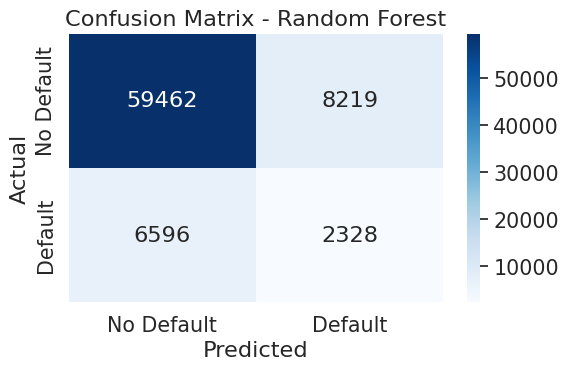

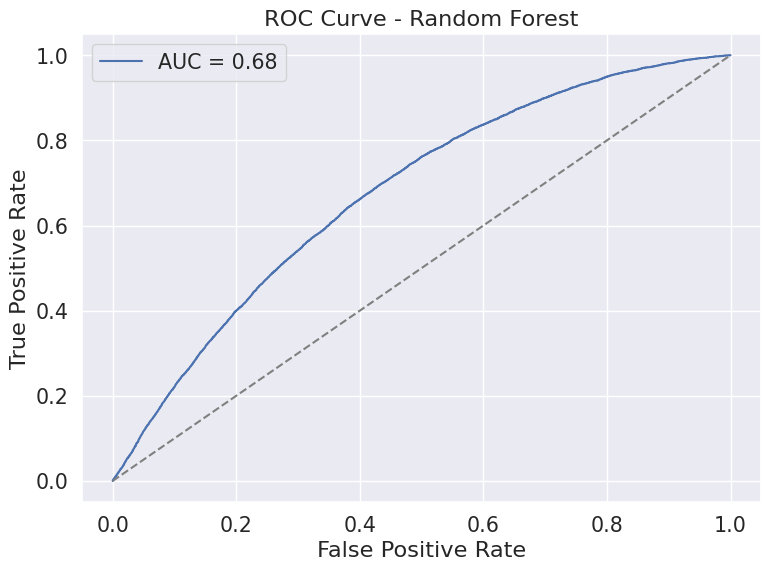

In [39]:
# Pruning y regularización

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,              # pruning: limita la profundidad máxima del árbol
    min_samples_split=10,      # pruning: mínimo de muestras para dividir un nodo
    min_samples_leaf=5,        # pruning: mínimo de muestras en una hoja
    max_features='sqrt',       # regularización: menos features por árbol -> menor varianza
    class_weight='balanced',   # regularización: ajusta pesos en clases desbalanceadas
    random_state=42
)

# Entrenamiento del modelo

rf.fit(X_resampled, y_resampled)

# Predicciones
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Informa de métricas
print("\nRandom Forest:")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

# Matriz de confusión

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

# Curva ROC

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**XGBOOST**

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     67709
           1       0.38      0.15      0.22      8896

    accuracy                           0.87     76605
   macro avg       0.64      0.56      0.58     76605
weighted avg       0.84      0.87      0.85     76605

F1 Score: 0.22017761420913673


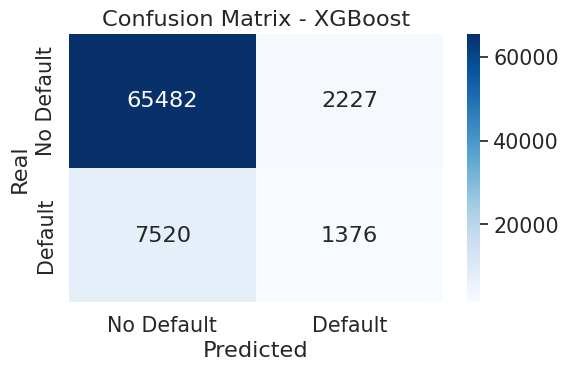

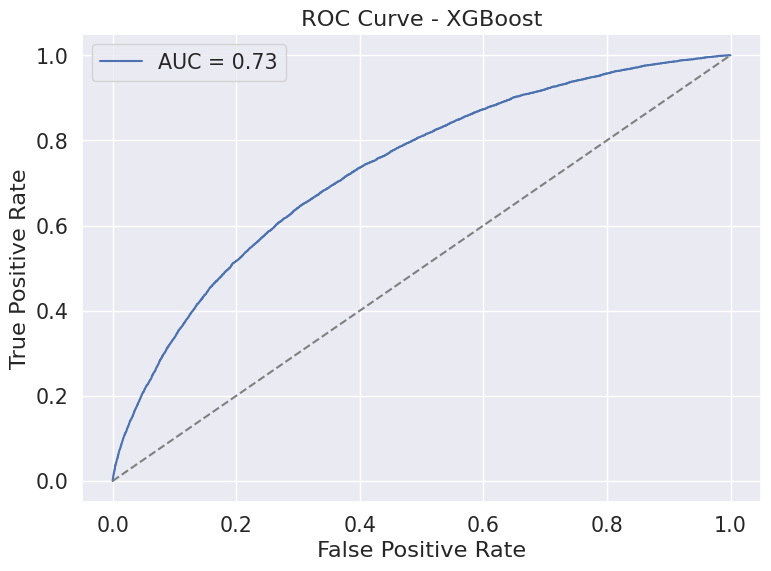

In [40]:
#SEMILLA

RANDOM_STATE = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# CODIFICACIÓN DE LAS VARIABLES CATEGÓRICAS

for col in X.select_dtypes(include=["object", "category", "bool"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# DIVISIÓN DEL DATASET

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=RANDOM_STATE)

# SMOTE

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ESCALAR VARIABLES NUMÉRICAS (OPCIONAL CON XGBOOST, PERO MEJORA EL RENDIMIENTO EN ALGUNOS CASOS)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ENTRENAMIENTO Y EVALUACIÓN DEL MODELO XGBOOST

# Modelo XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    nthread=1
)

# Entrenamiento
xgb.fit(X_train_res, y_train_res)

# Predicción
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# Métricas
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# MATRIZ DE CONFUSIÓN

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# CURVA ROC

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**LIGHTGBM**

[LightGBM] [Info] Number of positive: 157985, number of negative: 157985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4842
[LightGBM] [Info] Number of data points in the train set: 315970, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     67709
           1       0.59      0.08      0.14      8896

    accuracy                           0.89     76605
   macro avg       0.74      0.54      0.54     76605
weighted avg       0.86      0.89      0.85     76605

F1 Score: 0.13667561921814383


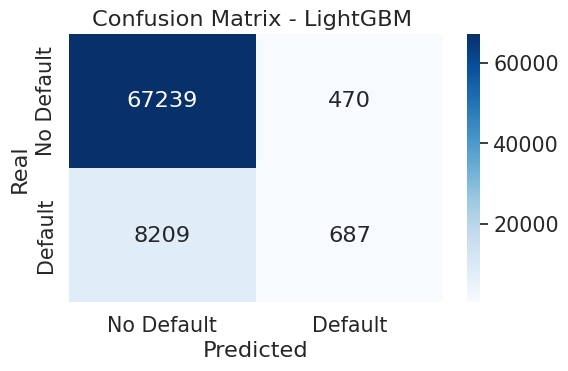

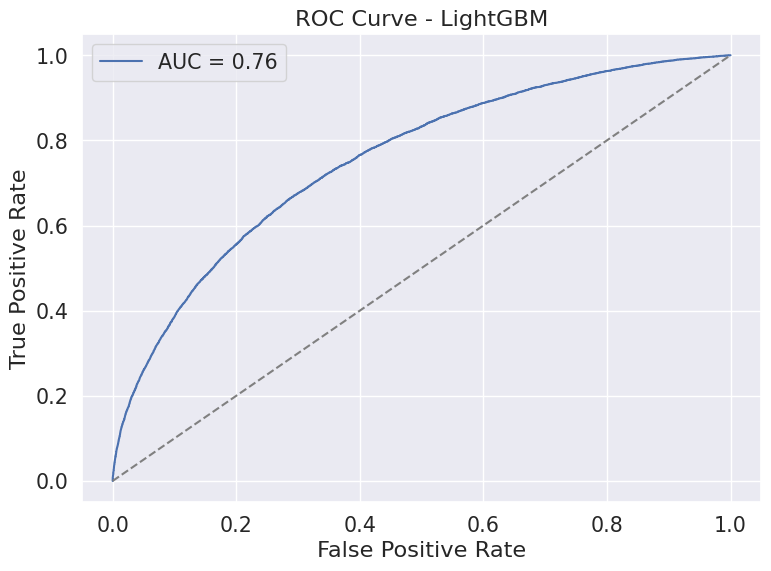

In [41]:
#SEMILLA

RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#ELIMINACIÓN DE LA VARIABLE OBJETIVO

y = df["Default"]
X = df.drop(columns="Default")

# DETECCIÓN DE VARIABLES CATEGÓRICAS Y NUMÉRICAS Y CARDINALIDAD

cat_base = ['CreditScoreCategory', 'LoanTermCategory', 'HasHighDebt']
cat_features = [col for col in cat_base if col in X.columns]

# Añadir otras categóricas solo si no están en cat_base
cat_features += [col for col in X.select_dtypes(include='object').columns if col not in cat_features]

# Mantener solo las de baja cardinalidad
# Ya no usamos set() para no perder el orden
cat_features = [col for col in cat_features if X[col].nunique() <= 50]
# Variables numéricas
num_features = df.select_dtypes(include=['int64', 'float64']) \
                 .drop(columns=['Default', 'Income_normalized', 'IncomeGroup'], errors='ignore') \
                 .columns.tolist()

# PREPROCESAMIENTO
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OrdinalEncoder(), cat_features)
    ],
    remainder='drop'
)

X_prepared = preprocessor.fit_transform(X)
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()
feature_names = num_features + feature_names_cat
X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names)

# DIVISIÓN DE DATASET Y TÉCNICA DE BALANCEO

# Splite
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared_df, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
# Smote
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ENTRENAMIENTO DEL MODELO LIGHTGBM

lgb = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=1
)

lgb.fit(X_train_res, y_train_res)

# INFORME DE MÉTRICAS

y_pred = lgb.predict(X_test)
y_proba = lgb.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# MATRIZ DE CONFUSIÓN
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - LightGBM ")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# CURVA ROC

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **MODELOS CON EL TOP 10 DEL MUTUAL INFORMATION**

**RANDOM FOREST**

In [42]:
#PREPROCESAMIENTO

# Selección de variables
top_features = ['Income', 'InterestRate', 'LoanAmount', 'Age', 'CreditScore',
                'MonthsEmployed', 'DTIRatio', 'LoanPurpose', 'LoanTerm', 'Education']

X_selected = df[top_features]
y = df["Default"]

# Preprocesamiento

cat_features = X_selected.select_dtypes(include='object').columns.tolist()
num_features = X_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OrdinalEncoder(), cat_features)
])

X_prepared = preprocessor.fit_transform(X_selected)

#  División train/test

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.3, stratify=y, random_state=42
)

# Crear DataFrame con nombres para SHAP
X_test_named = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

# Aplicar Smote
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.74      0.82     67709
           1       0.23      0.61      0.34      8896

    accuracy                           0.72     76605
   macro avg       0.58      0.67      0.58     76605
weighted avg       0.85      0.72      0.77     76605

Random Forest - F1: 0.3370730335322979


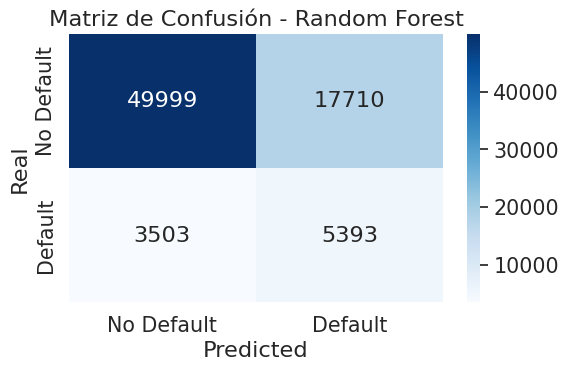

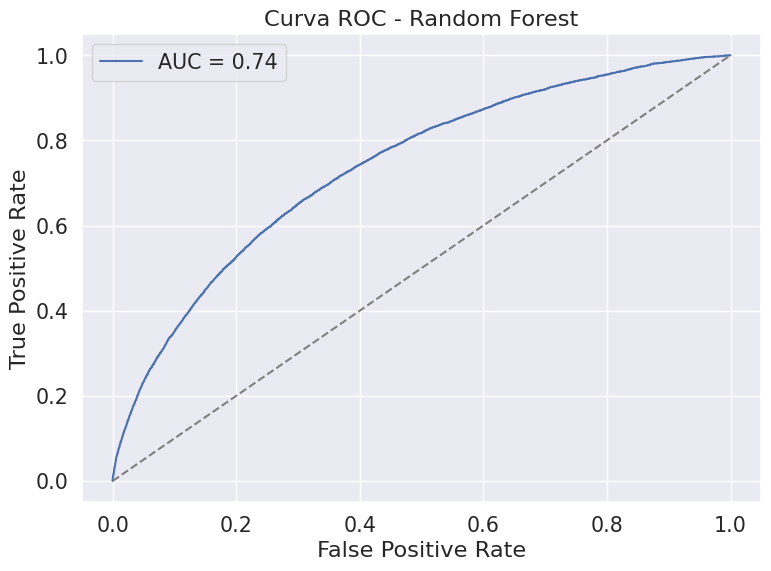

SHAP shape: (76605, 10)
X_test_named shape: (76605, 10)


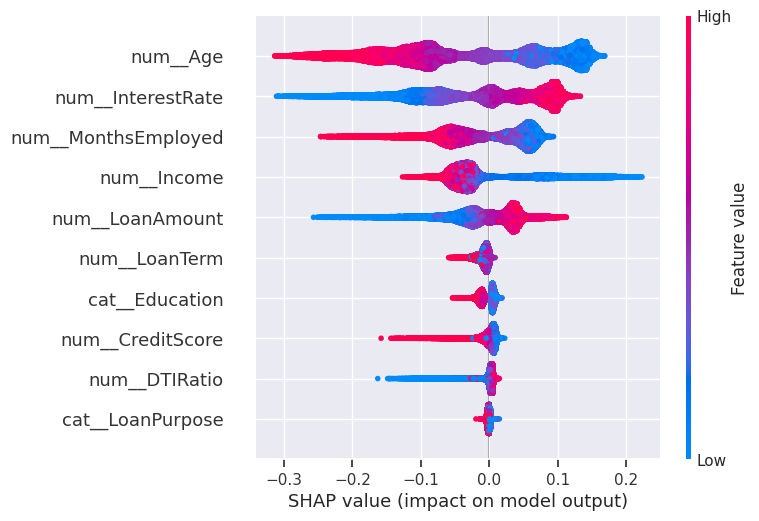

In [43]:
# MODELO DE RANDOM FOREST CON EL TOP 10 DEL MUTUAL INFORMATION

# Modelo Random Forest

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Reporte y visualizaciones
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest - F1:", f1_score(y_test, y_pred_rf))

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_score(y_test, y_proba_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Shap: explicabilidad

# Usar todo el conjunto de test con nombres correctos
X_test_named = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

# Crear el explicador SHAP
explainer = shap.TreeExplainer(rf)
shap_values_test = explainer.shap_values(X_test_named)

# Acceder correctamente si hay 2 clases (matriz 3D)
if len(shap_values_test.shape) == 3:
    shap_values_to_plot = shap_values_test[:, :, 1]  # Clase 1: impago
else:
    shap_values_to_plot = shap_values_test

# Confirmar shapes
print("SHAP shape:", shap_values_to_plot.shape)
print("X_test_named shape:", X_test_named.shape)

# Gráfico SHAP
shap.summary_plot(shap_values_to_plot, X_test_named)



**XGBOOST**

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     67709
           1       0.37      0.22      0.28      8896

    accuracy                           0.87     76605
   macro avg       0.64      0.59      0.60     76605
weighted avg       0.84      0.87      0.85     76605

XGBoost - F1: 0.2785534766824909


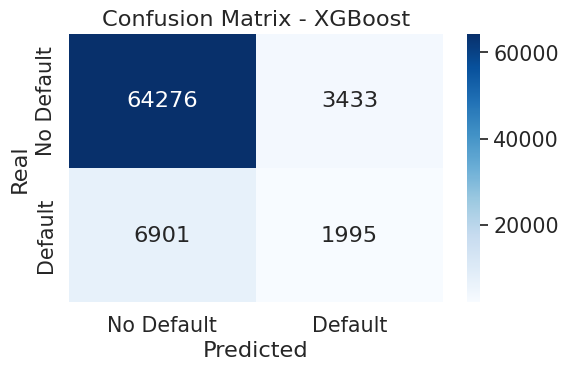

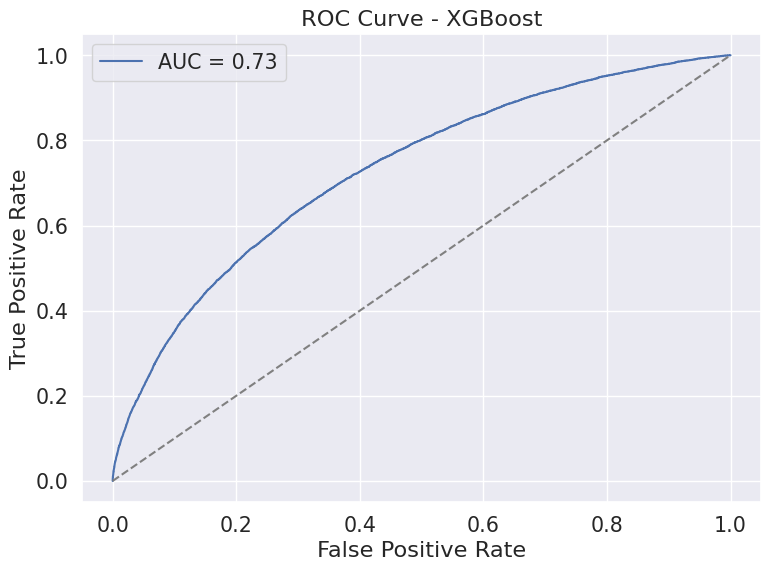

In [44]:
# MODELO DE XGBOOST CON EL TOP 10 DEL MUTUAL INFORMATION

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_res, y_train_res)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("XGBoost - F1:", f1_score(y_test, y_pred_xgb))

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Curva  ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_score(y_test, y_proba_xgb):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**LIGHTGBM**

[LightGBM] [Info] Number of positive: 157985, number of negative: 157985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 315970, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     67709
           1       0.50      0.10      0.17      8896

    accuracy                           0.88     76605
   macro avg       0.70      0.54      0.55     76605
weighted avg       0.85      0.88      0.85     76605

LightGBM - F1: 0.16800598019061858


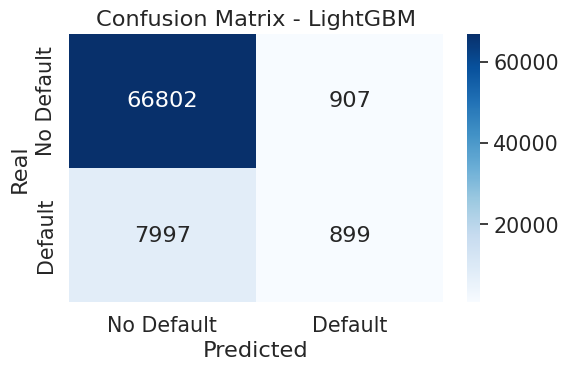

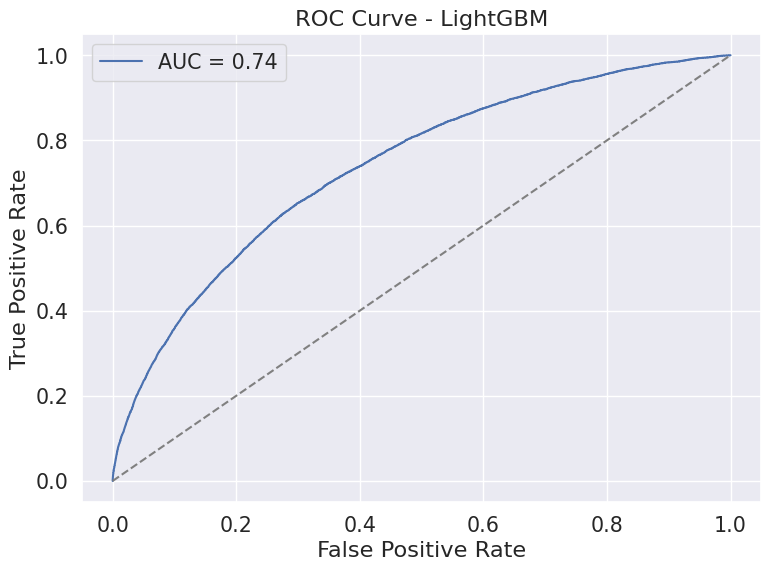

In [45]:
# MODELO DE LIGHTGBM CON EL TOP 10 DEL MUTUAL INFORMATION

lgb = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)
lgb.fit(X_train_res, y_train_res)

y_pred_lgb = lgb.predict(X_test)
y_proba_lgb = lgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lgb))
print("LightGBM - F1:", f1_score(y_test, y_pred_lgb))

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Curva ROC

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, label=f"AUC = {roc_auc_score(y_test, y_proba_lgb):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
